In [1]:
!git clone https://github.com/abhishek-choudharys/PokemonGAN

Cloning into 'PokemonGAN'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (131/131), done.
remote: Total 136 (delta 13), reused 106 (delta 1), pack-reused 0
Receiving objects: 100% (136/136), 53.24 MiB | 31.87 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
cd ../content/PokemonGAN

/content/PokemonGAN


In [0]:
run resize.py

In [0]:
run convertRGBAtoRGB.py

In [6]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
#import plot_utils
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython import display

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.2.0-rc4


In [7]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img_rgb = img[:, :, [2, 1, 0]]
        if img_rgb is not None:
            images.append(img_rgb)
    return images

images = load_images_from_folder('resized_RGB')
type(images)

list

In [8]:
import random
def grab_batch(images, batch_size):
    image_batch = np.zeros([32, 256, 256, 3])
    #image_batchx = np.empty()
    #print(np.asarray(random.sample(images, 1)).shape)
    for i in range(0, batch_size):
        image_batch[i,:,:,:] = np.asarray(random.sample(images, 1))[:,:,:]
        #image_batchx = np.append(image_batchx, np.asarray(random.sample(images, 1))[:,:,:])
    
    return image_batch
    
image_batch = np.asarray(grab_batch(images, 32))
image_batch = image_batch/255

print(type(image_batch))
print(image_batch.shape)

<class 'numpy.ndarray'>
(32, 256, 256, 3)


In [0]:
def show_batch(image_batch):
  print(type(image_batch))
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.axis('off')

In [0]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training = False)
    fig = plt.figure(figsize = (10,10))

    for i in range(25):
        plt.subplot(5, 5, i+1)
        plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
        plt.axis('off')
    
    plt.savefig('image_at_each_epoch_{:04d}.png'.format(epoch))
    plt.show()

<class 'numpy.ndarray'>


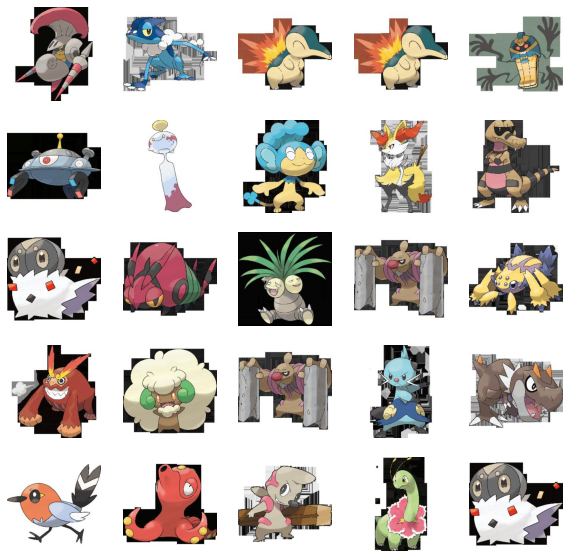

In [10]:
show_batch(image_batch) #from custom grab

In [14]:
num_features = 500

generator = keras.models.Sequential([
                                    keras.layers.Dense(8*8*256, input_shape = [num_features]), #dense layer
                                    keras.layers.Reshape([8,8,256]), #reshaped to 7*7 of 128
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2DTranspose(128, (5,5), (2,2), padding='same', activation='selu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2DTranspose(64, (5,5), (2,2), padding='same', activation='selu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2DTranspose(32, (5,5), (2,2), padding='same', activation='selu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2DTranspose(16, (5,5), (2,2), padding='same', activation='selu'),
                                    keras.layers.BatchNormalization(),
                                    keras.layers.Conv2DTranspose(3, (5,5), (2,2), padding='same', activation='tanh'),
])

generator.summary()

noise = tf.random.normal(shape = [1, num_features])

generated_image = generator(noise, training = False)
#show(generated_image, 1)

discriminator = keras.models.Sequential([
                                         keras.layers.Conv2D(64, (5,5), (2,2), padding='same', input_shape = [256, 256, 3]),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Conv2D(128, (5,5), (2,2), padding='same'),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Conv2D(256, (5,5), (2,2), padding='same'),
                                         keras.layers.LeakyReLU(0.2),
                                         keras.layers.Dropout(0.3),
                                         keras.layers.Flatten(),
                                         keras.layers.Dense(1, activation = 'sigmoid'),
                                         
])

discriminator.summary()

discriminator_output = discriminator(generated_image, training=False)
print(discriminator_output)

discriminator.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')
discriminator.trainable = False

gan = keras.models.Sequential([generator, discriminator])
gan.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16384)             8208384   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 256)         1024      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 16, 16, 128)       819328    
_________________________________________________________________
batch_normalization_6 (Batch (None, 16, 16, 128)       512       
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 64)        204864    
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 64)       

In [0]:
batch_size = 32
seed = tf.random.normal(shape = [batch_size, num_features])

In [0]:
def train_dcgan2(gan, dataset, batch_size, num_features, epochs = 5):
    generator, discriminator = gan.layers
    for epoch in tqdm(range(epochs)):
        print("Epoch : {}/{}".format(epoch+1, epochs))
        for i in range(0,100):
            X_batch = grab_batch(images, batch_size)
            noise = tf.random.normal(shape = [batch_size, num_features])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, X_batch], axis = 0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        display.clear_output(wait = True)
        generate_and_save_images(generator, epoch+1, seed)
    generate_and_save_images(generator, epochs, seed)


In [0]:
train_dcgan2(gan, train_generator, batch_size, num_features, epochs=10)